In [1]:
import numpy as np
import poke.poke_core as pol
import poke.raytrace as ray
import poke.plotting as plot

# Generating a Jones Pupil and propagating it with HCIPy 

In this example we will start with the computation of a Jones pupil using poke of the Hubble Space Telescope. Then we will use HCIPy to propagate to the image plane

In [2]:
# Initialize a Raybundle
nrays = 128
n1 = 1
n2 = 1.0194 - 1j*6.6388 # Al in v band
radius = 1.2
ffov = 0.08
wlen = 551e-9
pth = "C:/Users/douglase/Desktop/poke/test_files/Hubble_Test.zmx"

# Surface parameters are defined with Python dictionaries.
# 'surf' is the surface number in the raytrace lens data editor
# 'coating' is the thin film information. For a single layer, it's just the refractive index
s1 = {
    'surf':2,
    'coating':n2
}

s2 = {
    'surf':4,
    'coating':n2
}

raybundle = pol.Rayfront(nrays,wlen,radius,ffov,circle=True)
raybundle.as_polarized([s1,s2]) # pass the raybundle the surface list

norm fov =  [0. 0.]
base ray shape  (4, 12644)


In [3]:
# the surface data can be seen with the surfaces attribute
raybundle.surfaces

[{'surf': 2, 'coating': (1.0194-6.6388j)},
 {'surf': 4, 'coating': (1.0194-6.6388j)}]

## Still working on the code below, this is a problem with iPython and the zosapi

In [4]:
# Now propagate through the zemax optical system
raybundle.TraceRaysetZOS(pth,surfaces=[s1,s2])

FileNotFoundException: Could not load file or assembly 'ZOSAPI_Interfaces, Version=1.0.0.0, Culture=neutral, PublicKeyToken=null' or one of its dependencies. The system cannot find the file specified.
File name: 'ZOSAPI_Interfaces, Version=1.0.0.0, Culture=neutral, PublicKeyToken=null'
   at System.Signature.GetSignature(Void* pCorSig, Int32 cCorSig, RuntimeFieldHandleInternal fieldHandle, IRuntimeMethodInfo methodHandle, RuntimeType declaringType)
   at System.Reflection.RuntimeConstructorInfo.GetParametersNoCopy()
   at System.Reflection.MethodBase.GetParameterTypes()
   at System.Reflection.MethodBase.FormatNameAndSig(Boolean serialization)
   at System.Reflection.RuntimeConstructorInfo.ToString()
   at Python.Runtime.MethodObject..ctor(MaybeType type, String name, MethodBase[] info, Boolean allow_threads)
   at Python.Runtime.ClassManager.GetClassInfo(Type type, ClassBase impl)
   at Python.Runtime.ClassManager.InitClassBase(Type type, ClassBase impl, ReflectedClrType pyType)
   at Python.Runtime.ReflectedClrType.GetOrCreate(Type type)
   at Python.Runtime.ModuleObject.GetAttribute(String name, Boolean guess)
   at Python.Runtime.ModuleObject.LoadNames()
   at Python.Runtime.ImportHook.Import(String modname)
   at Python.Runtime.CLRModule._load_clr_module(PyObject spec)

WRN: Assembly binding logging is turned OFF.
To enable assembly bind failure logging, set the registry value [HKLM\Software\Microsoft\Fusion!EnableLog] (DWORD) to 1.
Note: There is some performance penalty associated with assembly bind failure logging.
To turn this feature off, remove the registry value [HKLM\Software\Microsoft\Fusion!EnableLog].


## For now, we open a pre-made rayset that's been pickled `raybundle_polarized.pickle` by the `gen_rayset` script

Keep in mind that pickle is not a secure data structure, and is only used here for example purposes until a more formal file structure is made for poke. Below is the warning from python

"It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never unpickle data that could have come from an untrusted source, or that could have been tampered with."

In [23]:
import pickle

with open("raybundle_polarized.pickle","rb") as f:
    raybundle = pickle.load(f)

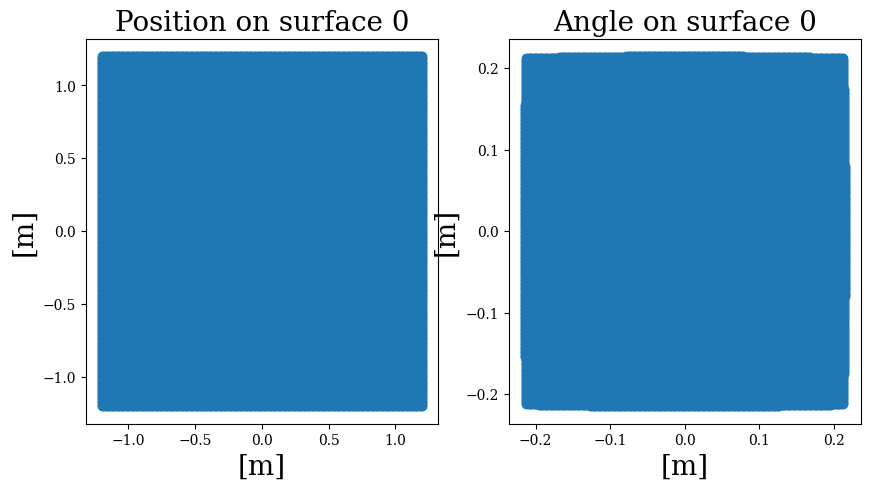

In [24]:
# The raybundle is back!
import matplotlib.pyplot as plt
raybundle.PlotRaysAtSurface(surf=0)

# Now Let's Compute a Jones Pupil using our data from above

In [25]:
# This is our surface data
raybundle.surfaces

[{'surf': 2, 'coating': (1.0194-6.6388j), 'mode': 'reflect'},
 {'surf': 4, 'coating': (1.0194-6.6388j), 'mode': 'reflect'}]

What we are doing here is a transformation from the PRT matrix (in global coordinates) to the Jones matrix (in local coordinates). This requires two vectors.
- _aloc_: which is the direction the optical axis is pointing in global coordinates
- _exit_x_: which direction will be the local x-axis after the transformation

In [26]:
# Compute the Jones Pupil from the ZOS raytrace and coating data
raybundle.ComputeJonesPupil(aloc=np.array([0.,0.,1.]),
                            exit_x=np.array([1.,0.,0.]))

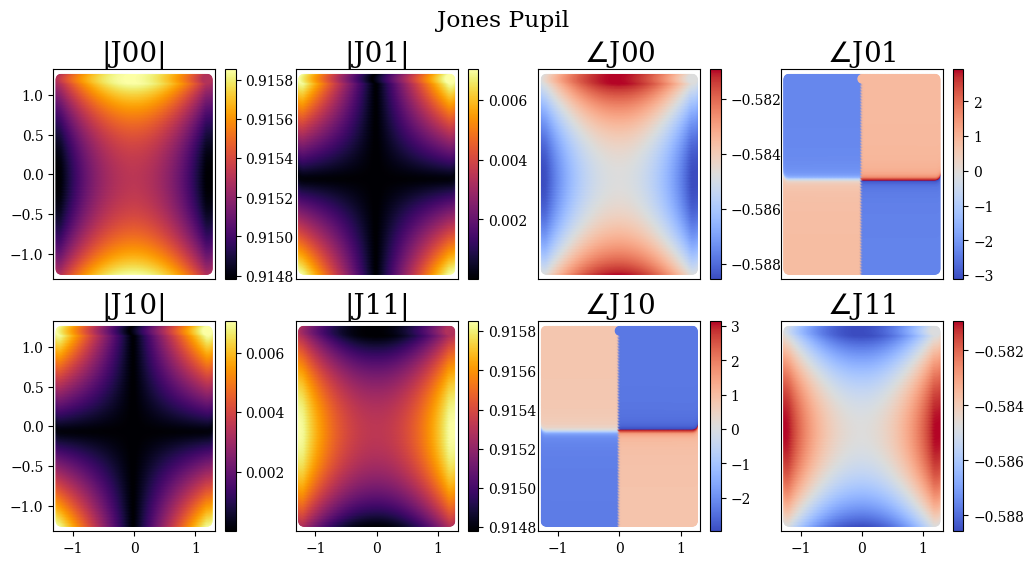

In [27]:
plot.JonesPupil(raybundle)

# Excellent, now we have a full description of the polarization-dependent transformation our optical system imposes on an incoming field!
Now, let's use our favorite diffraction propagators to compute a PSF!

## HCIPy's Partially Polarized Wavefront
HICPy is the only open-source high-contrast imaging simulator (to my knowledge) to have modules for polarization so we will be using one of them to compute the PSF of a generally polarized wavefront following this example [this example](https://docs.hcipy.org/0.3.1/tutorials/PolarizationIntro/PolarizationIntro.html) with some small modifications

In [10]:
from hcipy import *

In [32]:
# Grab the Jones Pupil as numpy arrays
J00 = raybundle.JonesPupil[0][...,0,0]#.reshape([256,256])
J01 = raybundle.JonesPupil[0][...,0,1]#.reshape([256,256])
J10 = raybundle.JonesPupil[0][...,1,0]#.reshape([256,256])
J11 = raybundle.JonesPupil[0][...,1,1]#.reshape([256,256])

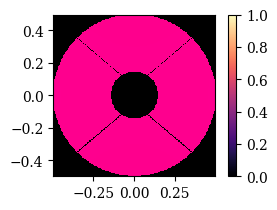

In [68]:
pupil_grid = make_pupil_grid(256)
aperture = make_magellan_aperture(True)(pupil_grid)

plt.figure()
imshow_field(aperture*J00)
plt.colorbar()

In [52]:
jones_matrix = Field([[aperture*J00,aperture*J01],[aperture*J10,aperture*J11]],pupil_grid)
stokes_vector = [1, 0.3, -0.2, 0.1]
partially_polarized_wavefront = Wavefront(jones_matrix, input_stokes_vector=stokes_vector)

In [53]:
def imshow_stokes_vector(wavefront):
    I_max = wavefront.I.max()

    plt.subplot(2, 2, 1)
    plt.title('I')
    imshow_field(wavefront.I, cmap='inferno')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title('Q')
    imshow_field(wavefront.Q, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.title('U')
    imshow_field(wavefront.U, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title('V')
    imshow_field(wavefront.V, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()


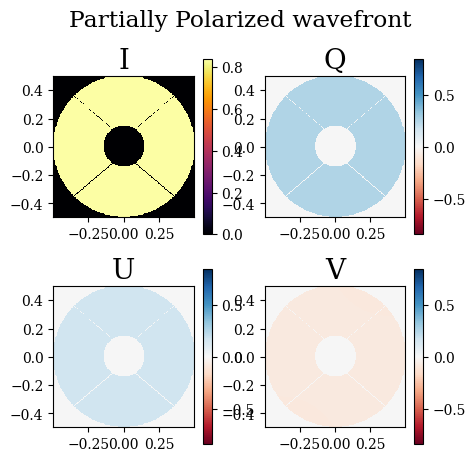

In [57]:
plt.figure(figsize=[5,5])
plt.suptitle('Partially Polarized wavefront')
imshow_stokes_vector(partially_polarized_wavefront)
plt.show()

# Time to send the wavefront throught the Fraunhofer Propagator

In [97]:
focal_grid = make_focal_grid(8, 8)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
partially_polarized_image = prop(partially_polarized_wavefront)

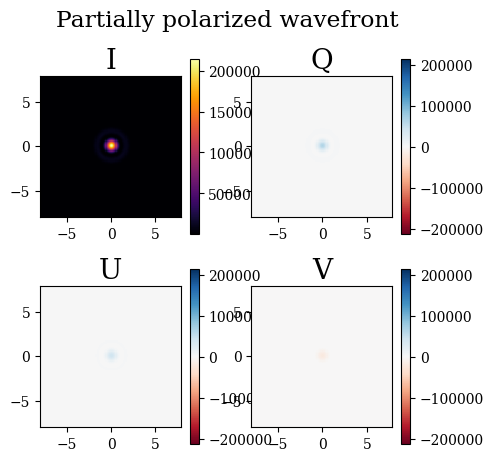

In [98]:
plt.figure(figsize=[5,5])
plt.suptitle('Partially polarized wavefront')
imshow_stokes_vector(partially_polarized_image)
plt.show()

# Now Pass this data through a linear polarizing beam splitter

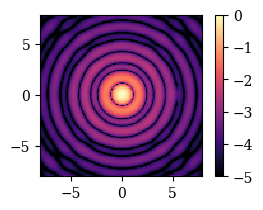

In [106]:
# Unpolarized Star
stokes_vector_planet = [1, 0.1, 0, 0]
contrast = 3e-4
angular_separation = 5 # lambda / D
num_photons_star = 1e9

wf_star = Wavefront(aperture)
wf_star.total_power = num_photons_star

e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
wf_planet.total_power = num_photons_star * contrast

# Calculate science image for the star and planet
science_image = prop(wf_star).power
science_image += prop(wf_planet).power

# Simulate photon noise
science_image = large_poisson(science_image)

imshow_field(np.log10(science_image / science_image.max() + 1e-20), vmin=-5, vmax=0)
plt.colorbar()
plt.show()

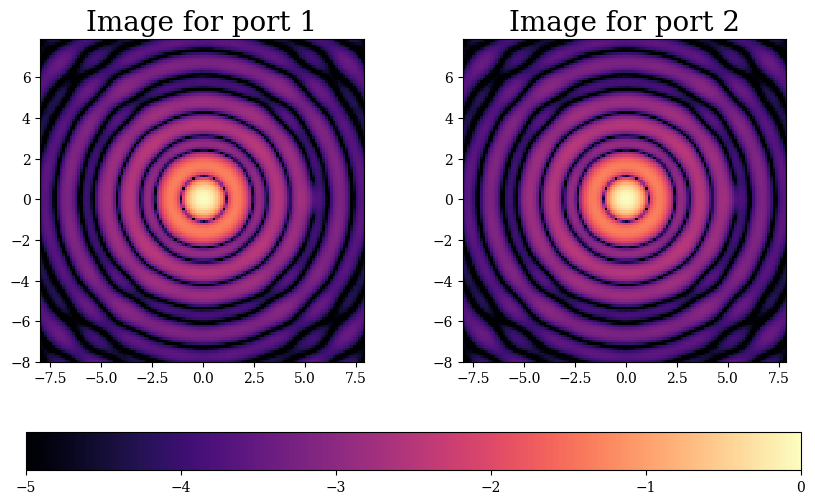

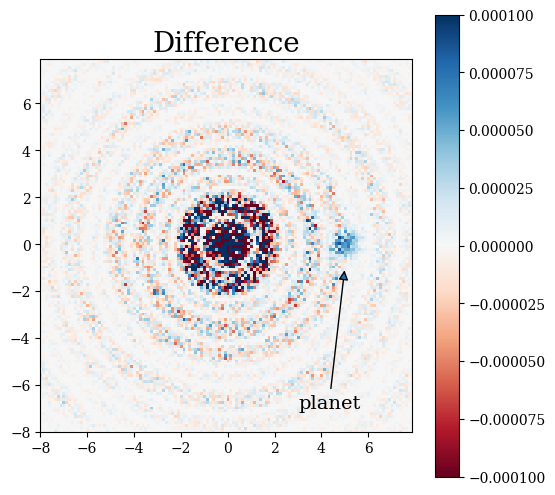

In [107]:
pbs = LinearPolarizingBeamSplitter(0)

img_star_1, img_star_2 = pbs(prop(wf_star))
img_planet_1, img_planet_2 = pbs(prop(wf_planet))

science_image_1 = img_star_1.power + img_planet_1.power
science_image_2 = img_star_2.power + img_planet_2.power

science_image_1 = large_poisson(science_image_1)
science_image_2 = large_poisson(science_image_2)

fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

axes[0].set_title('Image for port 1')
imshow_field(np.log10(science_image_1 / science_image_1.max() + 1e-20), vmin=-5, vmax=0, ax=axes[0])

axes[1].set_title('Image for port 2')
imshow_field(np.log10(science_image_2 / science_image_2.max() + 1e-20), vmin=-5, vmax=0, ax=axes[1])

plt.colorbar(ax=axes.tolist(), orientation="horizontal")
plt.show()

plt.figure(figsize=[6,6])
plt.title('Difference')
imshow_field((science_image_1 - science_image_2) / science_image_1.max(), cmap='RdBu',vmin=-1e-4,vmax=1e-4)
plt.annotate('planet', xy=(5, -1), xytext=(3, -7), arrowprops={'arrowstyle': '-|>'})
plt.colorbar()
plt.show()

# Great! Now let's try the same with Poppy
Poppy requires a good deal of hand-holding re: polarization because it doesn't support polarized propagation (yet!). But we can leverage what we know about the electric field to compute a simmilar result!

In [109]:
import poppy
import astropy.units as u

In [119]:
def FocusMagellan(JonesElement):
    
    """
    This treats the elements of the complex jones pupil as individual wavefronts that are then propagated
    """
    
    # Configure the JonesElement as a pupil wavefront error
    jones = poppy.ArrayOpticalElement()
    
    osys = poppy.OpticalSystem(pupil_diameter=1*u.m,oversample=2,npix=256)
    osys.add_pupil(poppy.AsymmetricSecondaryObscuration(secondary_radius=0.1*u.m,
                                             support_angle=(40, 140, 220, 320),
                                             support_width=[0.03, 0.03, 0.03, 0.03],
                                             support_offset_x=[0, 0, 0, 0],
                                             name='Complex secondary'))
    osys.add_pupil(poppy.CircularAperture(radius=0.5*u.m))
    osys.add_detector(pixelscale=0.01, fov_arcsec=4.0)
    
    psf = osys.calc_psf(wavelength=551e-9*u.m)
    return psf

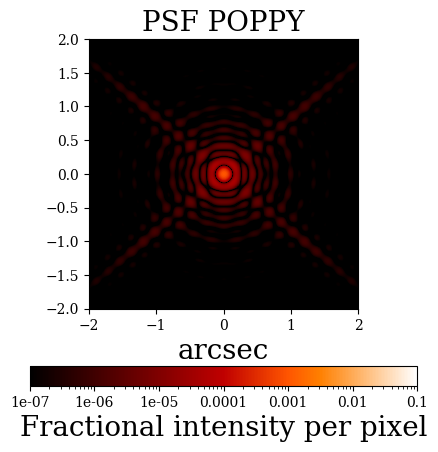

In [122]:
psf = FocusMagellan(1)
plt.figure(figsize=[5,5])
poppy.display_psf(psf, title='PSF POPPY',colorbar_orientation='horizontal')
plt.show()